In [1]:
using Revise
using SourceSeparationNF
using MLDatasets
using LinearAlgebra
using ProgressMeter
using Statistics
using PyPlot

BLAS.set_num_threads(1)

┌ Info: Precompiling SourceSeparationNF [0967cf83-991d-4407-9a5d-c519cfeee958]
└ @ Base loading.jl:1423


In [2]:
# fetch data
train_x, train_y = MNIST.traindata(dir = "../data/MNIST");

In [3]:
# prepare data
train_x_prep = convert(Matrix{Float64}, collect(reshape(train_x, (28*28, 60000))))
train_y_prep = zeros(10, length(train_y))
for k in 1:length(train_y)
    train_y_prep[train_y[k]+1, k] = 1
end

In [4]:
function create_neural_network(dim; optimizer::Type{<:AbstractOptimizer}=Adam, batch_size::Int=128)

    return Model(dim,
        (
            DenseLayer(dim, 8; optimizer=optimizer, batch_size=batch_size),
            ReluLayer(8; batch_size=batch_size),
            DenseLayer(8, 8; optimizer=optimizer, batch_size=batch_size),
            ReluLayer(8; batch_size=batch_size),
            DenseLayer(8, dim; optimizer=optimizer, batch_size=batch_size)
        )
    )

end

create_neural_network (generic function with 1 method)

In [5]:
batch_size = 128

model = Model(
    28*28,
    10,
    (
        MvAdditiveLayer(28*28, create_neural_network(28*14; batch_size=batch_size); batch_size=batch_size),
        PermutationLayer(28*28; batch_size=batch_size),
        MvAdditiveLayer(28*28, create_neural_network(28*14; batch_size=batch_size); batch_size=batch_size),
        DenseLayer(28*28, 10; batch_size=batch_size),
        SoftmaxLayer(10; batch_size=batch_size)
    )
);

In [6]:
isinvertible(model), nr_params(model)

(false, 21338)

In [7]:
setlr!(model, 1e-3)

In [8]:
# allocate for input image
input = Matrix{Float64}(undef, 28*28, batch_size)
output = Matrix{Float64}(undef, 10, batch_size)
loss_function = CCE(batch_size=batch_size);

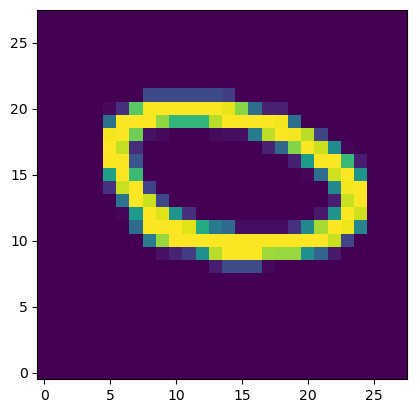

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\s151781\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


10-element Vector{Float64}:
 0.08929161043042058
 0.15867195328659187
 0.059913831782426735
 0.1343724522360301
 0.05403876586476064
 0.11499207592414035
 0.0782531791078313
 0.08665577798019224
 0.056710125293091794
 0.16710022809451444

In [9]:
# show initial prediction
using StatsFuns: softmax
input .= train_x_prep[:,1001:1000+batch_size]
plt.imshow(reshape(input[:,1], (28,28)), origin="lower")
softmax(forward!(model, input)[:,1])

In [10]:
nr_batches = length(1:batch_size:60_000-batch_size)
loss = Vector{Float64}(undef, nr_batches)
@showprogress for epoch in 1:50
    for k in 1:nr_batches
        # load data
        input .= train_x_prep[:,batch_size*(k-1)+1:batch_size*k]
        output .= train_y_prep[:,batch_size*(k-1)+1:batch_size*k]

        # train model
        loss[k] = mean(train!(model, input, output, loss_function))
    end
    println("epoch ", lpad(epoch, 3, "0"), ": ", mean(loss))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


epoch 001: 0.04973488344032695
epoch 002: 0.023895321921316742
epoch 003: 0.019761414758241995
epoch 004: 0.017563049880739336
epoch 005: 0.016032544056627098
epoch 006: 0.014835467086322706
epoch 007: 0.013939673286072509
epoch 008: 0.013228233109632878
epoch 009: 0.012589456848214184
epoch 010: 0.012089104631412594
epoch 011: 0.011613397999001717
epoch 012: 0.011217249158476255
epoch 013: 0.01086323231304683
epoch 014: 0.010528096572035371
epoch 015: 0.010239782619279564
epoch 016: 0.009997517651147442
epoch 017: 0.009743463959237421
epoch 018: 0.009518873570230475
epoch 019: 0.009273631990195538
epoch 020: 0.009096648991500316
epoch 021: 0.008935776025655855
epoch 022: 0.008749281215166478
epoch 023: 0.008639607448786894
epoch 024: 0.008455260021071968
epoch 025: 0.008355304756050527
epoch 026: 0.008181091084891092
epoch 027: 0.008057836451728504
epoch 028: 0.00792339584593485
epoch 029: 0.007806405220710972
epoch 030: 0.00768620362734465
epoch 031: 0.007573627834453495
epoch 032: 0

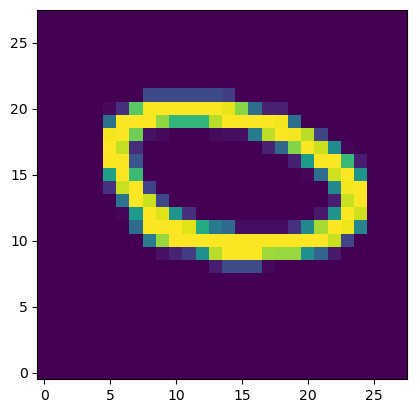

10-element Vector{Float64}:
 0.9970620051112693
 8.337647902740445e-13
 0.001056224827769048
 8.31671214300647e-6
 2.6726254489804832e-9
 1.7227090813718297e-5
 4.2994104566811616e-6
 6.256864378022172e-6
 2.0983543975583764e-5
 0.0018246837657352867

In [11]:
# show final prediction
using StatsFuns: softmax
input .= train_x_prep[:,1001:1000+batch_size]
plt.imshow(reshape(input[:,1], (28,28)), origin="lower")
softmax(forward!(model, input)[:,1])

In [12]:
using BenchmarkTools

In [13]:
@benchmark forward!($model)

BenchmarkTools.Trial: 3038 samples with 1 evaluation.
 Range (min … max):  945.600 μs …   4.664 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):       1.541 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.627 ms ± 466.434 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

      ▁▄▆▅▅▇▆▅▆▃▅▄▆█▆▄▂                                          
  ▄▆▅▆███████████████████▇▆▅▆▅▄▄▄▅▄▅▄▄▄▄▃▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂ ▅
  946 μs           Histogram: frequency by time         3.38 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [14]:
@benchmark propagate_error!($model)

BenchmarkTools.Trial: 1336 samples with 1 evaluation.
 Range (min … max):  2.111 ms … 12.397 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.553 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.706 ms ±  1.109 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▄▁▅▅█▅▃▄█▄▂▂▆▁▁▃▅▄▄▄▄▂▁▂    ▂                             
  ▄▇██████████████████████████▇▆█▇▆█▆▅▆▆▃▆▇▇▆▅▄▄▂▃▂▃▃▄▁▂▂▁▂▂ ▅
  2.11 ms        Histogram: frequency by time        6.75 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [15]:
@benchmark SourceSeparationNF.update!($model)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  226.200 μs …   3.755 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     275.500 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   307.689 μs ± 109.223 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃▅▅▄▃▆█▅▆▄▂▁▁▁                           ▁    ▁   ▁▁          ▂
  ████████████████▆▆▅▃▂▄▇▆▅▇▇▇▇▇▆▆▅▆▅▄▅▄▅▅▅████████▇██▇▆█▇▆▅▇▇▆ █
  226 μs        Histogram: log(frequency) by time        690 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [16]:
@benchmark train!($model, $input, $output, $loss_function)

BenchmarkTools.Trial: 1627 samples with 1 evaluation.
 Range (min … max):  2.265 ms …   7.760 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.987 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.055 ms ± 563.463 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▆▆█▆▇▃▁             ▁▁▂▃▂▁   ▁                            
  ▂▃████████▇▇▇▆▆▇▆▅▆▇▆▇███████▇█▆█▅▄▄▄▄▃▄▄▃▃▃▃▃▁▃▃▃▂▃▂▂▂▂▁▂▂ ▄
  2.26 ms         Histogram: frequency by time        4.75 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.